In [125]:
import numpy as np
import random

T = 1000
x_max = 100
# holding cost
h = 0.01
# purchase cost
c = 10
# selling price
p = 20
# order cost
K = 10
# Q = {}

V = np.array([[float(0) for i in range(T)] for j in range(x_max + 2)])
alpha = np.array([[float(0)for i in range(T)] for j in range(x_max + 2)])

# initialized the last column: hx
V[:, -1] = [x * h for x in range(0, x_max + 2)] 


for t in range(T - 2, -1, -1):
    c = 10 if t <= 500 else 15

    # P(D=1) distribution
    dIsOne = t / 1000
    dIsZero = 1 - dIsOne
    # P(d=1) increases linearly as t increases
    d = random.choices([1, 0], weights=(dIsOne, dIsZero), k = 1)[0]
    
    if t > 900:
        # At t > 900 no order can be placed, so the optimal policy would be just a copy of optimal policy at t = 900
        for x in range(0, x_max + 1):
            if x > 0:
                # reward only exists when x > 0 since no more action can be taken
                E = dIsOne * V[x - 1][t + 1] + dIsZero * V[x - 0][t + 1]  
                V[x][t] = (-h * x) + (dIsOne * p) + E
            else:
                # in case x = 0, x stays 0 for the rest of the time
                # Vx(t) = Vx(t+1) because no more profit can be made regardless the value of P(d=1)
                V[x][t] = V[x][t + 1]  
            # optimal policy remains unchanged after t = 900
            alpha[x][t]= alpha[x][t+1]

    # when  t <= 900
    else: 
        for x in range(0, x_max + 1):
            Q = {}
            for a in range(max(d-x,0) , x_max - x + d + 1):
                E = dIsOne * V[x - 1 + a][t + 1] + dIsZero * V[x - 0 + a][t + 1] 
                Q[a] = (-h * x) - K * (a > 0) - (c * a)  + (dIsOne * p) + E

            V[x][t] = Q[max(d-x, 0)]
            alpha[x][t]= max(d-x, 0)
            for a in range(max(d-x,0), x_max-x+d):
                if(Q[a] > V[x][t]):
                    alpha[x][t]=a
                    V[x][t] = Q[a]



for i in range(10 + 1):
    for j in range(990, T):
        print(V[i][j],end=' ')
    print() 

print('------------')

for i in range(10 + 1):
    for j in range(990, T):
        print(alpha[i][j], end = ' ')
    print()

print('------------')

for i in range(10 + 1):
    for j in range(0, 11):
        print(V[i][j],end=' ')
    print() 

print('------------')

for i in range(10 + 1):
    for j in range(0, 11):
        print(alpha[i][j], end = ' ')
    print()



0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
19.989899092749294 19.98990927492961 19.98991943662313 19.989929577891473 19.989939698782006 19.9899497970012 19.98995940024 19.98985006 19.95002 0.01 
39.96970756296519 39.96973807848757 39.96976853267274 39.969798925549256 39.96982923696082 39.9698564569376 39.96937073976 39.87002 19.950020000000002 0.02 
59.93943566403459 59.93949663318941 59.93955747896989 59.939618103128474 59.939667260912344 59.9383237860612 59.75998 39.860020000000006 19.95002 0.03 
79.89909361812079 79.89919512632659 79.89929607415904 79.89936448194938 79.89641312334483 79.61988 59.73998 39.85002 19.950020000000002 0.04 
99.8486916015852 99.84884265218793 99.84891585514563 99.84328613148142 99.44969999999999 79.58988 59.71998000000001 39.84002 19.95002 0.05 
119.78823704995878 119.78828242927119 119.77853520242958 119.24941999999999 99.40969999999999 79.55988 59.69998000000001 39.830020000000005 19.950020000000002 0.06 
139.71741660063455 139.70169956560773 139.019019999


### Choose appropriate X and A  use dynamic programming (programmed in 
python) to determine the total expected profit and the optimal order policy, 
starting with 0 inventory at time 0

- X(state) is  the current number of items in inventory max value of which can be
     x_max(currently 10 is used for simplicity of understanding) - current level + demand
- A(action) is placing an order 

In [26]:
aaa = np.zeros(x_max - x + d - max(d-x,0))
print(aaa)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Part B

In [120]:
import matplotlib.pyplot as plt

def plotter(Z, T, S, title):
    x = np.arange(0,T)
    y = np.arange(0,S+2)
    X,Y = np.meshgrid(x, y)
    fig = plt.figure(figsize=(7, 4), dpi=80)
    ax = fig.add_subplot(111)
    contour = ax.contourf(X, Y, Z, 20)
    fig.colorbar(contour)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("InventoryLevel", fontsize=12)
    plt.title(title, fontsize=14)
    plt.show()

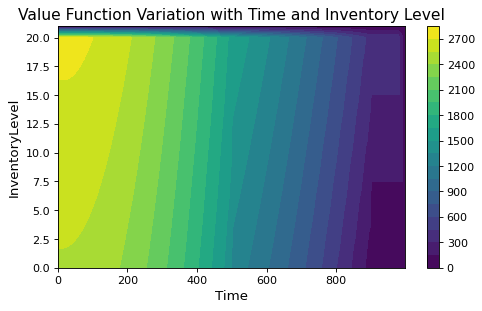

In [121]:
plotter(V, T, x_max, "Value Function Variation with Time and Inventory Level")

<AxesSubplot: >

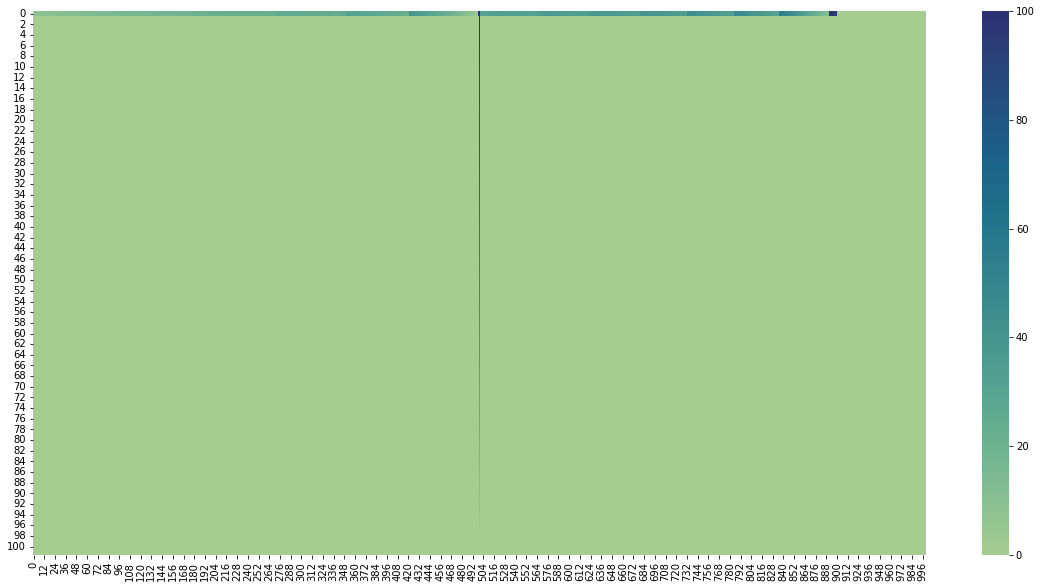

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns

# chunky plot
plt.subplots(1, 1, figsize=(20, 10))
sns.heatmap(alpha, cmap="crest")